In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
import pickle
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import warnings
import gc
import math
from sklearn.cluster import KMeans
from collections import Counter

warnings.simplefilter('ignore')

In [2]:
train_df = pd.read_parquet('data/train_df.parquet')

train_df['month'] = train_df['DateObserve'].dt.month
train_df['year'] = train_df['DateObserve'].dt.year
train_df['day'] = train_df['DateObserve'].dt.day

train_df['year'] -= train_df['year'].min()


train_df['num_month'] = train_df['year'] * 12 + train_df['month']
train_df = train_df[train_df['num_month']!=5]
train_df['num_day'] = train_df['month'] * 31 + train_df['day']
train_df = train_df.drop(['DateObserve', 'month', 'year'], axis=1)

tmp_df = train_df[train_df['StockStatus']==1][['WebPriceId', 'num_month']].drop_duplicates().groupby('WebPriceId').count()
goods = tmp_df[tmp_df['num_month']>=2].index
train_df = train_df[train_df['WebPriceId'].isin(goods)]

In [3]:
target = pd.read_excel('data/start_data/Y_train.xlsx')
target = pd.DataFrame({'target': target.drop('ИПЦ, мом', axis=1).iloc[1].values})
target['month'] = [x+train_df['num_month'].min() for x in range(len(target))]

In [4]:
all_cluster_features = []
for x in tqdm(range(11, 23)):
    if x == 15:
        continue
    
    cur_main_df = train_df[train_df['StockStatus']==1][(train_df['num_month']<=x)&(train_df['num_month']>=x-1)]

    tmp_df = cur_main_df[['WebPriceId', 'num_month']].drop_duplicates().groupby('WebPriceId').count()
    goods = tmp_df[tmp_df['num_month']>=2].index
    cur_main_df = cur_main_df[cur_main_df['WebPriceId'].isin(goods)]

    grouped = cur_main_df.groupby(['num_month', 'WebPriceId']).agg({'CurrentPrice': 'last'}).unstack()
    grouped = grouped.fillna(method='ffill').fillna(method='bfill')
    grouped.columns = grouped.columns.droplevel(0)

    month_change = np.exp(np.log((grouped.pct_change()+1)))
    month_change = month_change[month_change.index!=x-1]
    values = month_change.values.transpose(1,0)

    main = [values[x] for x in range(len(month_change.columns)) if np.array(values[x]).max() < 3 and np.array(values[x]).min()>0.33]

    for j in range(len(main)):
        new_val = [x for x in main[j] if x != 1]
        main[j] = new_val
        
    cluster_features = [[np.mean(y), np.median(y), np.std(y), len(y)] for y in main if len(y) > 0]
    all_cluster_features.append(cluster_features)
    
all_cluster_features = np.concatenate(all_cluster_features)
model = KMeans(n_clusters=6)
model.fit(all_cluster_features)
preds = model.predict(all_cluster_features)
good_cluster_classes = [x for x,y in dict(Counter(preds)).items() if y > len(all_cluster_features)/10]

100%|██████████| 12/12 [04:35<00:00, 22.93s/it]


In [5]:
all_features = []
all_target = []
for month in tqdm(range(10, 29)):
    if month == 15:
        continue
    
    for max_day in [10, 15, 20, 25, 31]:
    
        cur_features = []
        cur_main_df = train_df[((train_df['num_month']<month)&(train_df['num_month']>=month-3))|((train_df['num_month']==month)&(train_df['day']<=max_day))]    
        
        goods = cur_main_df[cur_main_df['num_month']>=2].index
        
        grouped = cur_main_df[cur_main_df['WebPriceId'].isin(goods)].groupby(['num_month', 'WebPriceId']).agg({'CurrentPrice': 'last'}).unstack()
        grouped = grouped.fillna(method='ffill').fillna(method='bfill')
        grouped.columns = grouped.columns.droplevel(0)

        month_change = np.exp(np.log((grouped.pct_change()+1)))
        month_change = month_change[month_change.index!=month-3]
                
        values = month_change.values.transpose(1,0)
        main = [values[x] for x in range(len(month_change.columns)) if np.array(values[x]).max() < 2.5 and np.array(values[x]).min()>0.4]
        for j in range(len(main)):
            new_val = [x for x in main[j] if x != 1]
            main[j] = new_val
        cluster_features = [[np.mean(y), np.median(y), np.std(y), len(y)] for y in main if len(y) > 0]
        preds = model.predict(cluster_features)
        c = month_change.columns.tolist()
        for j in good_cluster_classes:
            good_cols = [c[x] for x in range(len(preds)) if preds[x] == j]
            cur_df = cur_main_df[cur_main_df['WebPriceId'].isin(good_cols)]
            
            tmp_df = cur_df[['WebPriceId', 'num_month']].drop_duplicates().groupby('WebPriceId').count()
            goods = tmp_df[tmp_df['num_month']>=2].index
            cur_df = cur_df[cur_df['WebPriceId'].isin(goods)]

            cur_df = cur_df[cur_df['WebPriceId'].isin(cur_df[cur_df['num_month']==month]['WebPriceId'].unique())]

            grouped = cur_df.groupby(['num_month', 'WebPriceId']).agg({'CurrentPrice': 'last'}).unstack()
            grouped = grouped.fillna(method='ffill').fillna(method='bfill')
            grouped.columns = grouped.columns.droplevel(0)


            month_change = np.exp(np.log((grouped.pct_change()+1)))
            month_change = month_change[month_change.index==month]

            values = month_change.dropna(axis=1).values[0]
            sort_values = [x for x in values if 0.4 < x < 2.5]
            
            cur_features.append([np.average(sort_values, weights=[0.2 if x > 1.6 else 1 for x in sort_values])-1])
            cur_features.append([np.average(sort_values)-1, np.std(sort_values)])
            
            
        all_features.append(np.concatenate(cur_features))
        all_target.append(target[target['month']==month+1]['target'].tolist()[0])

100%|██████████| 19/19 [06:05<00:00, 19.26s/it]


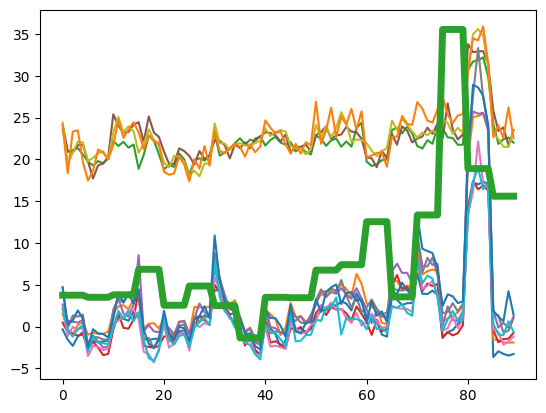

In [6]:
for x in range(len(all_features[0])):
    plt.plot(np.array(all_features)[:, x]*100)
plt.plot(np.array(all_target)*10, linewidth=5)

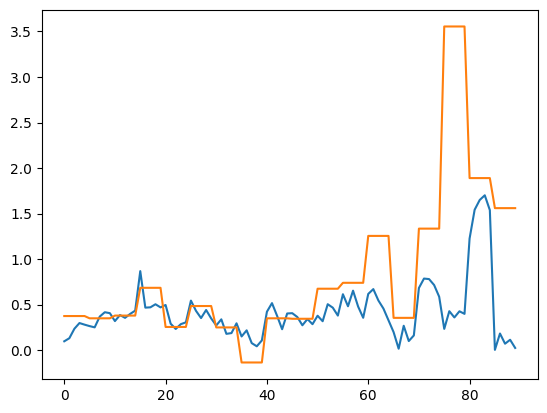

In [7]:
main_model = LinearRegression()
main_model.fit(all_features[:int(len(all_features)*0.5)], all_target[:int(len(all_features)*0.5)])
pred = main_model.predict(all_features)
plt.plot(pred)
plt.plot(all_target)

In [8]:
with open('models/main_model.pkl', 'wb') as f:
    pickle.dump(main_model, f)
    
with open('models/cluster_model.pkl', 'wb') as f:
    pickle.dump((model, good_cluster_classes), f)